# Hyperopt without using sacred
The example function to optimize is:
$$x^2+y^2$$

Where x and y have added Gaussian noise with $\mu=0$ and $\sigma=1$.

This document shows examples of both sequential and parellel optimization.

In [1]:
import os
import math
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import hyperopt
from hyperopt import hp
from hyperopt.mongoexp import MongoTrials

# My imports
import objective

# Some parameters
n_trials = 250
local_avg_length = 15
n_workers = 5
jobs_per_worker = int(math.ceil(n_trials/n_workers))
db_name = "hopt-min"

### Set uninformative uniform priors over the parameters $x$ and $y$

In [2]:
search_space = dict(x=hp.uniform("x", -10, 10),
                    y=hp.uniform("y", -5, 20))

# Sequential optimization
Run trials sequentially with no parallelization.
Here the optimization is done twice with different algorithms:
1. Random search (sampling randomly from the priors)
2. A Bayesian algorithm called TPE (tree of Parzen estimators)
 which should improve the search results over time.

## Random Search

In [3]:
random_trials_seq = hyperopt.Trials()
hyperopt.fmin(objective.hyperopt_objective,
              space=search_space,
              algo=hyperopt.rand.suggest,
              max_evals=n_trials,
              trials=random_trials_seq,
              verbose=2)

100%|██████████| 250/250 [00:50<00:00,  3.86it/s, best loss: 0.2124269684632802]


{'x': 0.03536207074846942, 'y': -0.38197562676078967}

## TPE Search

In [4]:
tpe_trials_seq = hyperopt.Trials()
hyperopt.fmin(objective.hyperopt_objective,
              space=search_space,
              algo=hyperopt.tpe.suggest,
              max_evals=n_trials,
              trials=tpe_trials_seq,
              verbose=2)

100%|██████████| 250/250 [00:52<00:00,  4.16it/s, best loss: 0.12431234907648625]


{'x': 0.7433216932906337, 'y': 0.6226799925334161}

## Compare the Results

Random Search Best Loss: 0.2124269684632802
TPE Search Best Loss: 0.12431234907648625


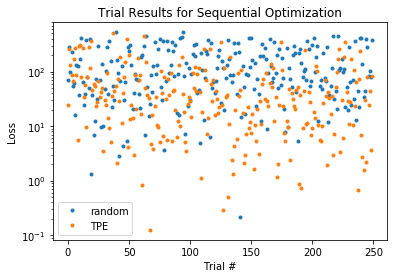

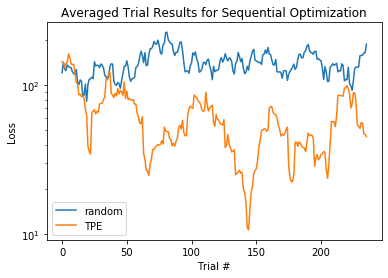

In [5]:
print(f"Random Search Best Loss: {min(random_trials_seq.losses())}")
print(f"TPE Search Best Loss: {min(tpe_trials_seq.losses())}")

# Trial Results
plt.plot(random_trials_seq.losses(), ".", label="random")
plt.plot(tpe_trials_seq.losses(), ".", label="TPE")
plt.yscale("log")
plt.xlabel("Trial #")
plt.ylabel("Loss")
plt.title("Trial Results for Sequential Optimization")
plt.legend()
plt.show()

# Averaged trial results
convolve_array = np.ones(local_avg_length, dtype=float) / local_avg_length
plt.plot(scipy.signal.convolve(random_trials_seq.losses(), convolve_array, mode="valid"), 
         "-", label="random")
plt.plot(scipy.signal.convolve(tpe_trials_seq.losses(), convolve_array, mode="valid"), 
         "-", label="TPE")
plt.yscale("log")
plt.xlabel("Trial #")
plt.ylabel("Loss")
plt.title("Averaged Trial Results for Sequential Optimization")
plt.legend()
plt.show()

# Parallel Search
Now we will try parallel optimization using mongodb.

Firstly, the database used must be defined.

In [6]:
hopt_address = (f"mongo://{os.environ['MONGO_WRITE_IP']}:{os.environ['MONGO_PORT']}/" +
                db_name + "/jobs")
hopt_address

'mongo://localhost:27184/hopt-min/jobs'

## Running the parellel search
To run the parallel search, the function calls are done by another process.

After calling the `fmin` function,
the hyperopt workers can be started by running the script:
`bash hopt-workerN.sh hopt-min X`,
where `X` is the number of jobs that process is meant to complete (for example, 100 or 200).

In this notebook though, the workers will be run in a subprocess to save time
and make the examples easier to follow.

## Previous database results
Note that if there are previous results in the database, the trials won't be run since the database is full.

If needed, the database can be cleared by using the aliased command `clear_db`.
For example, in this notebook, the command would be:

In [7]:
f"clear_db {db_name}"

'clear_db hopt-min'

## Random Search

In [8]:
# Set up the sub-processes
for i in range(n_workers):
    subprocess.Popen(f"bash hopt-workerN.sh {db_name} {jobs_per_worker}".split())

# Run the actual optimization (should finish super fast)
rand_trials_par = MongoTrials(hopt_address, exp_key="rand")
argmin = hyperopt.fmin(objective.hyperopt_objective,
                       space=search_space,
                       algo=hyperopt.rand.suggest,
                       max_evals=n_trials,
                       trials=rand_trials_par,
                       verbose=2)

  0%|          | 0/250 [00:00<?, ?it/s, best loss: ?]

no last_id found, re-trying



286it [04:54,  1.02s/it, best loss: 1.4388892605309604]                         


## TPE Search

In [9]:
# Set up the sub-processes
for i in range(n_workers):
    subprocess.Popen(f"bash hopt-workerN.sh {db_name} {jobs_per_worker}".split())

# Run the actual optimization (should finish super fast)
tpe_trials_par = MongoTrials(hopt_address, exp_key="tpe")
argmin = hyperopt.fmin(objective.hyperopt_objective,
                       space=search_space,
                       algo=hyperopt.tpe.suggest,
                       max_evals=n_trials,
                       trials=tpe_trials_par,
                       verbose=2)

289it [04:56,  1.03s/it, best loss: 0.03413324471859318]                         


## Compare the Results

Random Search Best Loss: 1.4388892605309604
TPE Search Best Loss: 0.03413324471859318


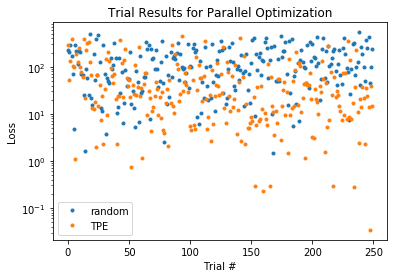

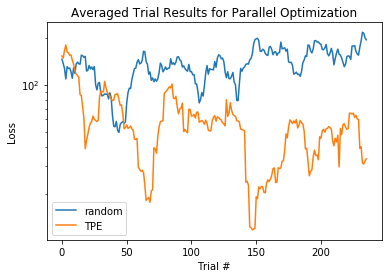

In [10]:
print(f"Random Search Best Loss: {min(rand_trials_par.losses())}")
print(f"TPE Search Best Loss: {min(tpe_trials_par.losses())}")

# Trial Results
plt.plot(rand_trials_par.losses(), ".", label="random")
plt.plot(tpe_trials_par.losses(), ".", label="TPE")
plt.yscale("log")
plt.xlabel("Trial #")
plt.ylabel("Loss")
plt.title("Trial Results for Parallel Optimization")
plt.legend()
plt.show()

# Averaged trial results
convolve_array = np.ones(local_avg_length, dtype=float) / local_avg_length
plt.plot(scipy.signal.convolve(rand_trials_par.losses(), convolve_array, mode="valid"), 
         "-", label="random")
plt.plot(scipy.signal.convolve(tpe_trials_par.losses(), convolve_array, mode="valid"), 
         "-", label="TPE")
plt.yscale("log")
plt.xlabel("Trial #")
plt.ylabel("Loss")
plt.title("Averaged Trial Results for Parallel Optimization")
plt.legend()
plt.show()

# Conclusions
- TPE does much better than random search, both absolutely and on average
- Parallel search is actually slower in this case, likely because the function to optimize is so simple that the overhead costs are high.